In [1]:
"""A deep MNIST classifier using convolutional layers.
See extensive documentation at
https://www.tensorflow.org/get_started/mnist/pros
"""
"""
https://github.com/tensorflow/tensorflow/blob/r1.2/tensorflow/examples/tutorials/mnist/mnist_deep.py
"""
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from __future__ import print_function
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from tensorflow.examples.tutorials.mnist import input_data

# Environments

In [2]:
"""
Please note, the environments for the codes.
"""

import platform

print(platform.linux_distribution())

print(platform.python_version())

print(tf.__version__)

print(np.__version__)

('Ubuntu', '14.04', 'trusty')
2.7.6
1.0.1
1.12.1


# Load Data

In [3]:
mnist = input_data.read_data_sets('./mnist', one_hot=True)

Extracting ./mnist/train-images-idx3-ubyte.gz
Extracting ./mnist/train-labels-idx1-ubyte.gz
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Extracting ./mnist/t10k-labels-idx1-ubyte.gz


In [4]:
img =  mnist.train.images[np.random.randint(0, 55000, size = 100), :].reshape(-1, 28, 28)

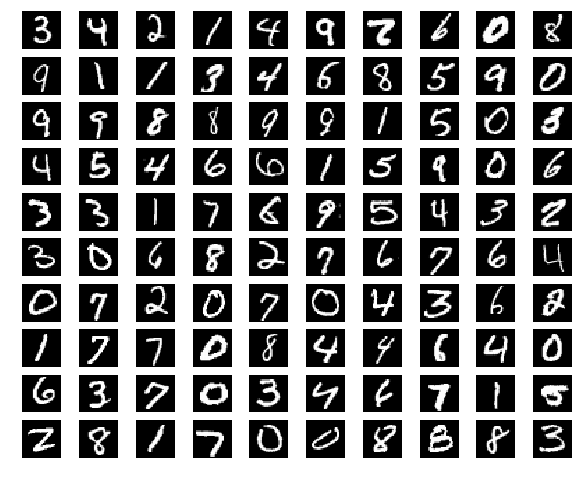

In [5]:
## refer to stanford cs231n assignment2 for the imshow_noax()
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')
    
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, i * 10 + j + 1)
        imshow_noax(img[i * 10 + j, :])
plt.show()

# Model

In [11]:
def conv2d(x, W):
    """a 2-D convolution layer with full stride """
    return tf.nn.conv2d(x, W, strides = [1, 1, 1, 1], padding = 'SAME')

def max_pool_2x2(x):
    """max pool by 2x2 """
    return tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')


def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)


def experts_model(X):
    """
    Deep NN :
        (1) 5x5 Convolutional Layer with 32 filters and stride of 1
        (2) ReLU Activation Layer
        (3) 2x2 Max Pooling layer with a stride of 2
    
        (4) 5x5 Convolutional Layer with 64 filters and stride of 1
        (5) ReLU Activation Layer
        (6) 2x2 Max Pooling layer with a stride of 2
    
        (7) Affine layer with 1024 output units
        (8) ReLU Activation Layer
    
        (9) Dropout layer
    
        (10) Affine layer from 1024 input units to 10 outputs
        
    Args:
        X: an input tensor with  dimensions (None, 28X28=784)
        
    Returns:
        A tuple (y_out, keep_prob)
       
    """
    X0 = tf.reshape(X, [-1, 28, 28, 1])
    
    ## (1) 5x5 Convolutional Layer with 32 filters and stride of 1
    ## (2) ReLU
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(X0, W_conv1) + b_conv1)
    
    ## (3) 2x2 Max Pooling
    h_pool1 = max_pool_2x2(h_conv1)    ## 14 X 14 X 32

    
    ## (4) 5x5 conv with 64 filters and stride of 1
    ## (5) ReLU
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)   
    
    ## (6) 2x2 Max Pooling
    h_pool2 = max_pool_2x2(h_conv2)    ## 7 x 7 x 64

    
    ## (7) Affine layer with 1024 output units
    ## (8) ReLU Activation Layer
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])
    
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])   
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
    ## (9) dropout
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    ## (10) Affine layer from 1024 input units to 10 outputs
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    y_out = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    
    return y_out, keep_prob
    
    

# Graph

In [12]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

## loss
y_out, keep_prob = experts_model(X)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = y_out, labels = y)
mean_loss = tf.reduce_mean(cross_entropy)

## train
train_step = tf.train.AdamOptimizer(1e-4).minimize(mean_loss) 

## test
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_out, 1)) 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Training

Iter         0, training batch accuracy 0.1
Iter       200, training batch accuracy 0.93
Iter       400, training batch accuracy 0.92
Iter       600, training batch accuracy 0.94
Iter       800, training batch accuracy 0.98
Iter      1000, training batch accuracy 0.97
Iter      1200, training batch accuracy 0.99
Iter      1400, training batch accuracy 0.97
Iter      1600, training batch accuracy 0.98
Iter      1800, training batch accuracy 0.99
Iter      2000, training batch accuracy 1
Iter      2200, training batch accuracy 0.99
Iter      2400, training batch accuracy 0.99
Iter      2600, training batch accuracy 0.99
Iter      2800, training batch accuracy 0.99
Iter      3000, training batch accuracy 0.98
Iter      3200, training batch accuracy 1
Iter      3400, training batch accuracy 1
Iter      3600, training batch accuracy 0.99
Iter      3800, training batch accuracy 0.99
Iter      4000, training batch accuracy 1
Iter      4200, training batch accuracy 1
Iter      4400, training b

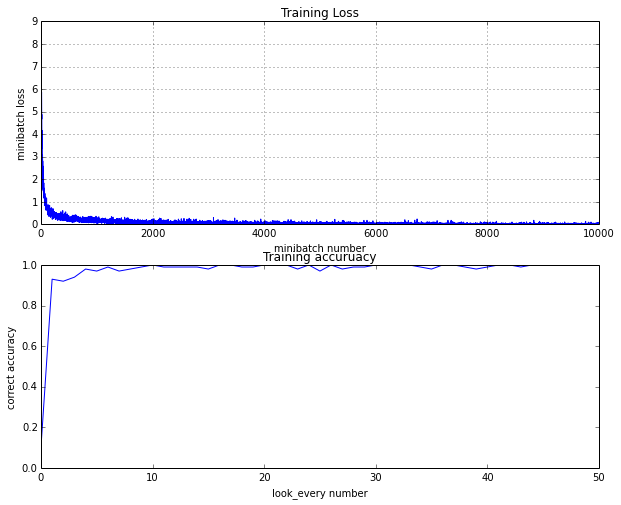

0.9893


In [27]:
init = tf.global_variables_initializer()

sess = tf.Session()
with tf.device("/gpu:0") as dev:
    sess.run(init)
    
    losses = []
    train_accuracies = []
    for i in range(10000): 
        batch_X, batch_y = mnist.train.next_batch(100)  
        
        if i % 200 == 0:
            train_accuracy = sess.run(accuracy, feed_dict = {X: batch_X, y: batch_y, keep_prob: 1.0})
            train_accuracies.append(train_accuracy)
            print('Iter %9d, training batch accuracy %g' % (i, train_accuracy))
        
        loss, _ = sess.run([mean_loss, train_step], feed_dict={X: batch_X, y: batch_y, keep_prob: 0.5})
        losses.append(loss)
     
    plt.subplot(2, 1, 1)
    plt.plot(losses)
    plt.grid(True)
    plt.title('Training Loss')
    plt.xlabel('minibatch number')
    plt.ylabel('minibatch loss')
    
    plt.subplot(2, 1, 2)
    plt.plot(train_accuracies)
    plt.title("Training accuruacy")
    plt.xlabel("look_every number")
    plt.ylabel("correct accuracy")
    
    
    plt.show()    
        
    feed_dict = {X: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0}
    test_acc = sess.run(accuracy, feed_dict = feed_dict)
        
    print(test_acc)